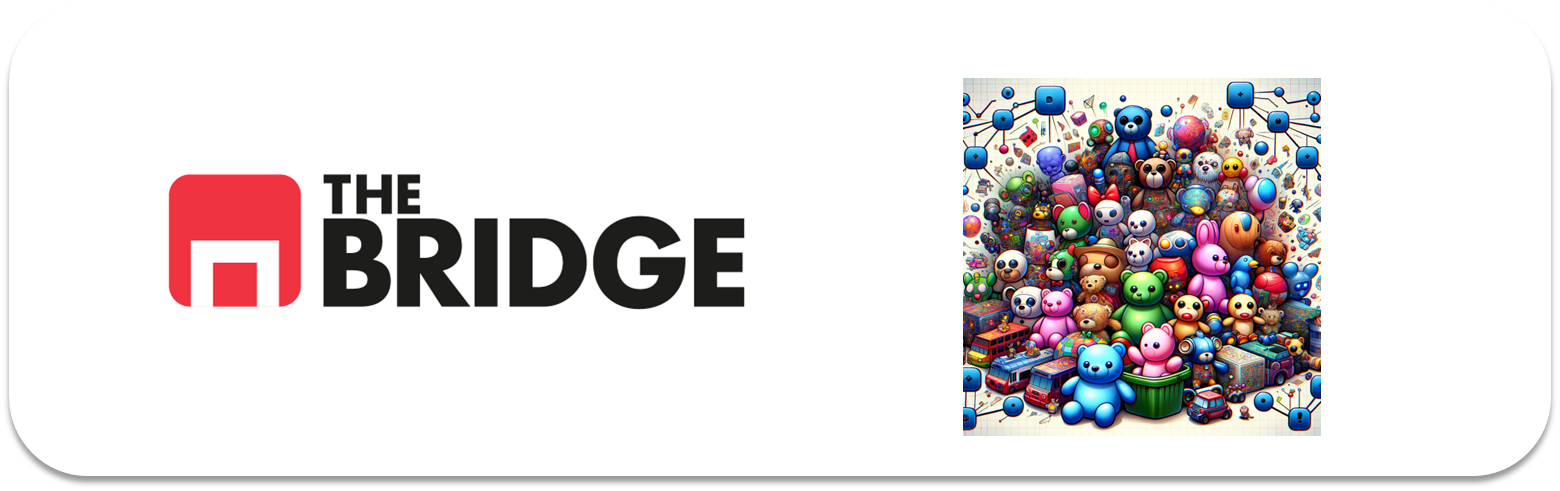

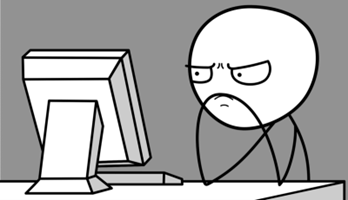

Para ejercitarte y afianzar lo aprendido sobre **K-Means**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [141]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Entendiendo el problema de negocio

En este notebook vamos a hacer un análisis de datos tirando de clusterizaciones para evaluar si existen grupos en nuestros productos, en este caso medicamentos, y posteriormente poder etiquetarlos. Poseemos información como rating, efectividad, efectos secundarios, entre otros.

### Ejercicio 1

Importa los datos, "./data/drugLibTrain_raw.tsv", que contiene un dataset con diferentes fármacos, sus efectos y ratings de los clientes de dichos fármacos. Realiza una inspección preliminar y quita las columnas que consideres innecesarias.

In [142]:
df = pd.read_csv("./data/drugLibTrain_raw.tsv", sep="\t")
df

,url,DrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above
...,...,...,...,...,...,...,...,...,...
3102,1039,vyvanse,10,Highly Effective,Mild Side Effects,adhd,"Increased focus, attention, productivity. Bett...","Restless legs at night, insomnia, headache (so...","I took adderall once as a child, and it made m..."
3103,3281,zoloft,1,Ineffective,Extremely Severe Side Effects,depression,Emotions were somewhat blunted. Less moodiness.,"Weight gain, extreme tiredness during the day,...",I was on Zoloft for about 2 years total. I am ...
3104,1664,climara,2,Marginally Effective,Moderate Side Effects,total hysterctomy,---,Constant issues with the patch not staying on....,---
3105,2621,trileptal,8,Considerably Effective,Mild Side Effects,epilepsy,Controlled complex partial seizures.,"Dizziness, fatigue, nausea",Started at 2 doses of 300 mg a day and worked ...


### Ejercicio 2: MiniEDA

Como es un problema no supervisado (vamos a intentar agrupar los medicamentos sin tener una referencia o target inicial), no hay split, vamos directos al miniEDA. Analiza qué variables son descartables en función de su porcentaje de cardinalidad. Es decir obten la cardinalidad y su porcentaje para cada posible feature y crea un dataset nuevo descartando las features que creas conveniente. NOTA: Como simplificación, descarta la columna con url.

In [143]:
df.drop(columns=["url", "DrugName"], inplace=True)

In [144]:
features = []
for col in df.columns:
    cardinalidad = df[col].nunique() / len(df)*100
    print(col, round(cardinalidad, 4))
    if cardinalidad < 30:
        features.append(col)

rating 0.3219
effectiveness 0.1609
sideEffects 0.1609
condition 45.8964
benefitsReview 97.5539
sideEffectsReview 90.5375
commentsReview 98.0367


### Ejercicio 3

Construye un train set (llámalo X) sólo con las features que hayas seleccionado del ejercicio anterior (es decir las que no hayas descartado como posibles features) 

In [145]:
X = df[features]

In [146]:
X

,rating,effectiveness,sideEffects
0,4,Highly Effective,Mild Side Effects
1,1,Highly Effective,Severe Side Effects
2,10,Highly Effective,No Side Effects
3,3,Marginally Effective,Mild Side Effects
4,2,Marginally Effective,Severe Side Effects
...,...,...,...
3102,10,Highly Effective,Mild Side Effects
3103,1,Ineffective,Extremely Severe Side Effects
3104,2,Marginally Effective,Moderate Side Effects
3105,8,Considerably Effective,Mild Side Effects


In [147]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   rating         3107 non-null   int64 
 1   effectiveness  3107 non-null   object
 2   sideEffects    3107 non-null   object
dtypes: int64(1), object(2)
memory usage: 72.9+ KB


### Ejercicio 4 

Trasforma las features que consideres necesario (categóricas y numéricas) y luego aplica el escalado que consideres necesario.

In [148]:
X["sideEffects"].unique()

array(['Mild Side Effects', 'Severe Side Effects', 'No Side Effects',
       'Extremely Severe Side Effects', 'Moderate Side Effects'],
      dtype=object)

In [149]:
side_effects = ["No Side Effects", "Mild Side Effects", "Moderate Side Effects", "Severe Side Effects", "Extremely Severe Side Effects"]

ordinal = OrdinalEncoder(categories=[side_effects])
X["sideEffects"] = ordinal.fit_transform(X[["sideEffects"]])

In [150]:
effect_map = {'Highly Effective': 4, 'Marginally Effective': 1, 'Ineffective': 0,
       'Considerably Effective': 3, 'Moderately Effective': 2}

X['effectiveness'] = X['effectiveness'].map(effect_map)

In [151]:
minmax = MinMaxScaler()
X[X.columns] = minmax.fit_transform(X)

In [152]:
X

,rating,effectiveness,sideEffects
0,0.333333,1.00,0.25
1,0.000000,1.00,0.75
2,1.000000,1.00,0.00
3,0.222222,0.25,0.25
4,0.111111,0.25,0.75
...,...,...,...
3102,1.000000,1.00,0.25
3103,0.000000,0.00,1.00
3104,0.111111,0.25,0.50
3105,0.777778,0.75,0.25


### Ejercicio 5: Otención de K, aproximación visual

Analiza la relación entre features (con scatter plots) una vez transformadas para comprobar si existe visualmente algún indicio del número de clústeres que podríamos estar buscando. Por otro lado este análisis nos puede hacer descartar alguna feature o generar una nueva

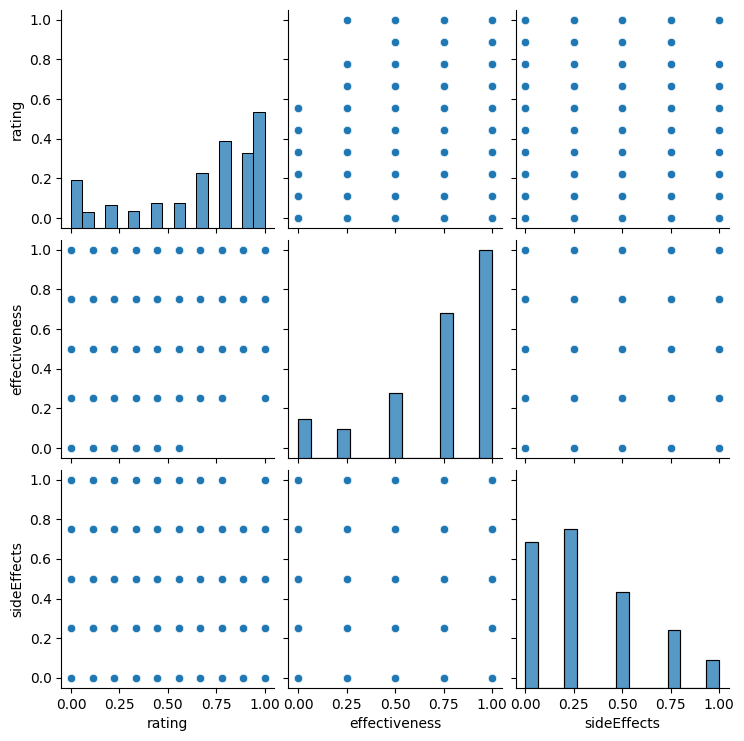

In [153]:
sns.pairplot(X)

### Ejercicio 6: Obtención de K, método del codo

Evalua diferentes valores K y escoge uno a partir del método del codo/elbow de inercia.

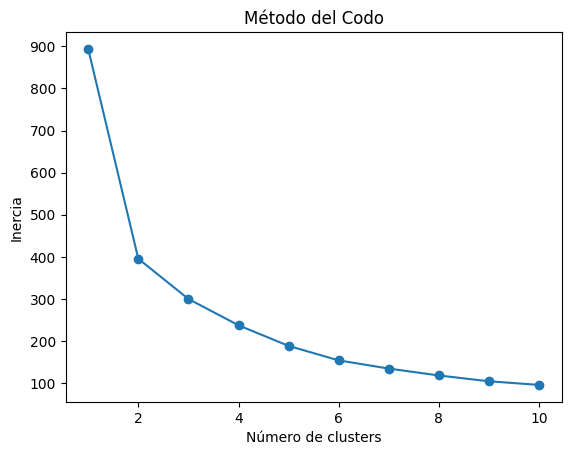

In [154]:


# Lista para almacenar los valores de la inercia
inertia = []

# Probamos con diferentes valores de k
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Graficamos la suma de los cuadrados de las distancias en función de k
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()


In [155]:
ks = []
inercias = []

for k in range(1,11):
    clustering = KMeans(k)
    clustering.fit(X)
    ks.append(k)
    inercias.append(clustering.inertia_)

df_inercias = pd.DataFrame({"k": ks, "inercia":inercias})
df_inercias

,k,inercia
0,1,893.992575
1,2,395.471897
2,3,299.907623
3,4,236.926652
4,5,188.300987
5,6,153.959304
6,7,134.169973
7,8,117.759799
8,9,106.285603
9,10,95.023209


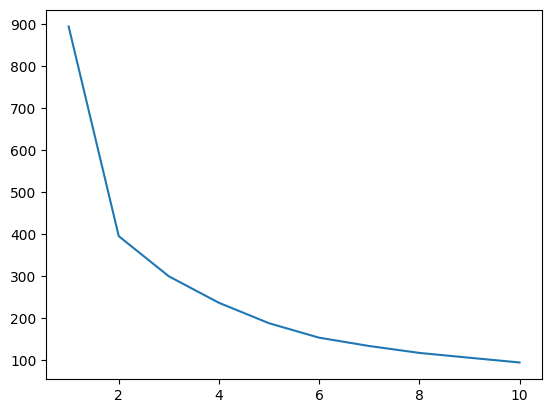

In [156]:
plt.plot(ks, inercias)

### Ejercicio 7: Obtención de K, Score de Silueta

Comprueba el ajuste de k obteniendo el k que maximiza el score de silueta y pinta un gráfico de la evolución de dicho score con k. Usa los valores de k que hayas probado en el ejercicio anterior.

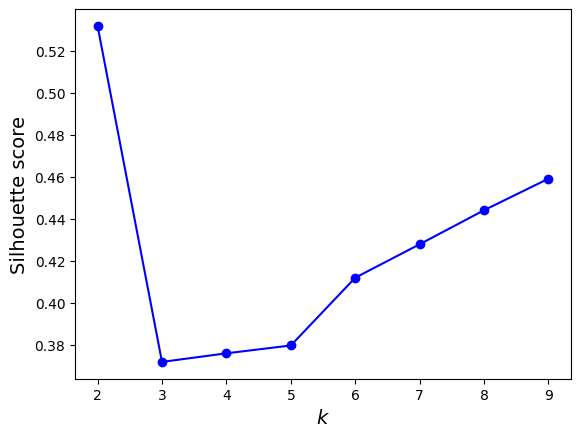

In [157]:
#Calculamos el silhouette score para cada k
ks = []
sil_scores = []

for k in range(2, 10): 
    clustering = KMeans(n_clusters = k)
    clustering.fit(X)

    sil_scores.append(silhouette_score(X, clustering.labels_))
    ks.append(k)


# Graficamos el silhouette score para cada k
plt.plot(ks, sil_scores, "bo-");
plt.xlabel("$k$", fontsize=14);
plt.ylabel("Silhouette score", fontsize=14);

### Ejercicio 8: Obtención de K, diagrama de silueta

Para completar el estudio de k, muestra el diagramde silueta para k=2,3,4,5 y decide con este datos y los anteriores el valor de k a probar. NOTA: En la realidad, podríamos probar perfectamente k=2 y k=3 y luego que "Negocio" decidiera cuál le es más útil, aquí lo completamos por practicar todo lo aprendido

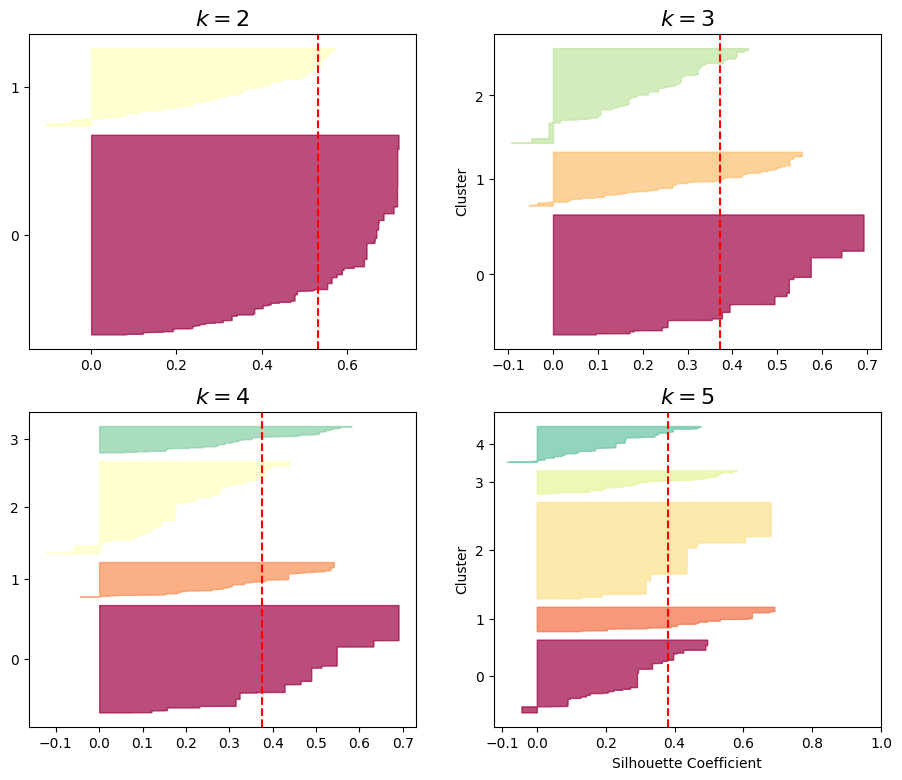

In [158]:

from matplotlib.ticker import FixedLocator, FixedFormatter

'''
La anchura de cada cuchillo representa el numero de muestras por cluster. Están ordenadas
por su coeficiente de silhouette, por eso tiene esa forma de cuchillo. Cuanta más caida tenga
indica que las muestras tienen un coeficiente mas disperso en ese cluster
Deberian estar todos los clusters por encima de la media.
Hay algunas lineas hacia la izda xq es el coeficiente negativo. Puntos asignados al cluster erroneo.
'''
plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    clustering = KMeans(n_clusters = k)
    clustering.fit(X)
    y_pred = clustering.labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = matplotlib.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=True)

    plt.axvline(x=sil_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)


plt.show()

### Ejercico 9:

En general, una diferencia entre el proceso de construcción de un modelo no supervisado y un supervisado es que el ajuste de algunos hiperparámetros (como el número de clústeres) es anterior a la construcción del modelo. Por eso, construye un K-means para el valor (o valores) de K escogidos.

In [159]:
clustering_2 = KMeans(2)
clustering_2.fit(X)

KMeans(n_clusters=2)

### Ejercicio 10

Vamos a comprobar resultados, analizando los valores medios y distribución de cada uno de los clústeres para el k óptimo. Si tuvieras más de un posible valor de k a probar, analiza aquí el de mayor score de silueta. Y utiliza el siguiente ejercicio para el otro. Además de hacer un describe de las features por clúster, pinta estos con un pairplot considerando sideEffects y rating como x e y (o viceversa) y el clúster como hue (color). Compara el resultado con los clústeres sugeridos en el ejercicio 5.

In [160]:
X["cluster"] = clustering_2.predict(X)
X

,rating,effectiveness,sideEffects,cluster
0,0.333333,1.00,0.25,1
1,0.000000,1.00,0.75,0
2,1.000000,1.00,0.00,1
3,0.222222,0.25,0.25,0
4,0.111111,0.25,0.75,0
...,...,...,...,...
3102,1.000000,1.00,0.25,1
3103,0.000000,0.00,1.00,0
3104,0.111111,0.25,0.50,0
3105,0.777778,0.75,0.25,1


In [161]:
X.groupby("cluster").describe()

rating                                                              \
          count      mean       std  min       25%       50%       75%  max   
cluster                                                                       
0         869.0  0.216596  0.208818  0.0  0.000000  0.222222  0.333333  1.0   
1        2238.0  0.842369  0.146383  0.0  0.777778  0.888889  1.000000  1.0   

        effectiveness            ...           sideEffects            \
                count      mean  ...  75%  max       count      mean   
cluster                          ...                                   
0               869.0  0.387514  ...  0.5  1.0       869.0  0.626295   
1              2238.0  0.868409  ...  1.0  1.0      2238.0  0.209674   

                                              
              std  min  25%   50%   75%  max  
cluster                                       
0        0.281846  0.0  0.5  0.75  0.75  1.0  
1        0.202298  0.0  0.0  0.25  0.25  1.0  

[2 rows x 24 columns]

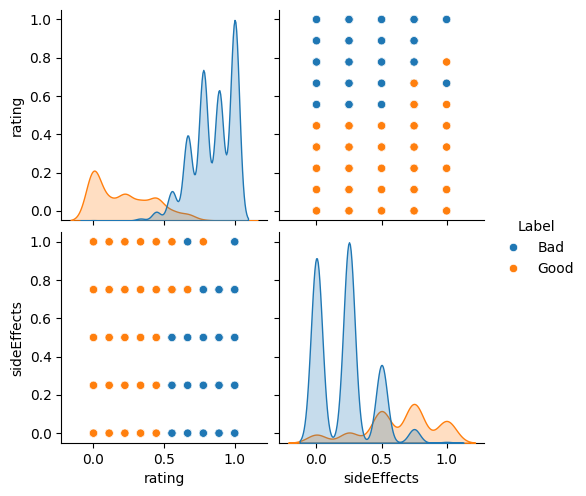

In [162]:
cluster_map = {0: 'Good', 1: 'Bad'}
X['Label'] = X['cluster'].map(cluster_map)
sns.pairplot(data= X[['rating', 'sideEffects', 'Label']], hue= 'Label');

### Ejercicio 11, EXTRA: Más valores de K

Repite el análisis del ejercicio 10 para un K diferente pero que consideres que tiene sentido aplicar.

In [163]:
X.drop(columns=["cluster", "Label"], inplace=True)

clustering_3 = KMeans(3)
clustering_3.fit(X)

X["cluster"] = clustering_3.predict(X)
X

,rating,effectiveness,sideEffects,cluster
0,0.333333,1.00,0.25,0
1,0.000000,1.00,0.75,1
2,1.000000,1.00,0.00,2
3,0.222222,0.25,0.25,1
4,0.111111,0.25,0.75,1
...,...,...,...,...
3102,1.000000,1.00,0.25,2
3103,0.000000,0.00,1.00,1
3104,0.111111,0.25,0.50,1
3105,0.777778,0.75,0.25,0


In [165]:
X.groupby("cluster").describe()

rating                                                              \
          count      mean       std       min       25%       50%       75%   
cluster                                                                       
0        1097.0  0.652993  0.166477  0.000000  0.555556  0.666667  0.777778   
1         622.0  0.122544  0.142220  0.000000  0.000000  0.111111  0.222222   
2        1388.0  0.922831  0.095026  0.444444  0.888889  1.000000  1.000000   

                  effectiveness            ...           sideEffects  \
              max         count      mean  ...  75%  max       count   
cluster                                    ...                         
0        1.000000        1097.0  0.736098  ...  1.0  1.0      1097.0   
1        0.555556         622.0  0.290595  ...  0.5  1.0       622.0   
2        1.000000        1388.0  0.930836  ...  1.0  1.0      1388.0   

                                                         
             mean       std  min   25%   50%   75%  max  
cluster                                                  
0        0.406791  0.210430  0.0  0.25  0.50  0.50  1.0  
1        0.664389  0.294553  0.0  0.50  0.75  1.00  1.0  
2        0.110951  0.131990  0.0  0.00  0.00  0.25  0.5  

[3 rows x 24 columns]

In [166]:
cluster_map = {0: 'Mid', 1: 'Bad', 2:'Good'}
X["label"] = X["cluster"].map(cluster_map)

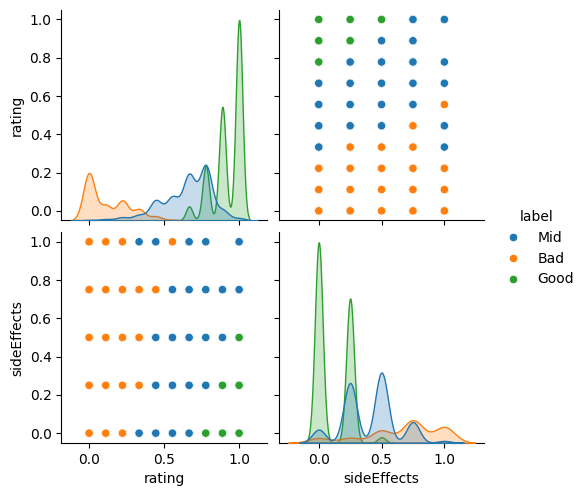

In [168]:
#Podemos ver la distribucion de los clusters en el espacio de las variables
sns.pairplot(data= X[['rating', 'sideEffects', 'label']], hue= 'label');